# Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

In [1]:
# импорт библиотек
import pandas as pd
print(pd.__version__)
import numpy as np
print(np.__version__)
import seaborn as sns
print(sns.__version__)
from scipy import stats as st
from matplotlib import pyplot as plt

1.3.5
1.21.6
0.11.2


In [55]:
try:
    data_calls = pd.read_csv('calls.csv')
    data_internet = pd.read_csv('internet.csv', index_col=0)
    data_messages = pd.read_csv('messages.csv')
    data_tariffs = pd.read_csv('tariffs.csv')
    data_users = pd.read_csv('users.csv')
except:
    data_calls = pd.read_csv('/datasets/calls.csv')
    data_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
    data_messages = pd.read_csv('/datasets/messages.csv')
    data_tariffs = pd.read_csv('/datasets/tariffs.csv')
    data_users = pd.read_csv('/datasets/users.csv')

### Проверка data_calls

In [38]:
data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [10]:
data_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [67]:
# проверка на дубликаты
print(f'Найдено дубликатов: {data_calls.duplicated().sum()}')

Найдено дубликатов: 0


In [68]:
# приведение типов данных
# call_date to datatime
DATA = '%Y-%m-%d'
data_calls.call_date = pd.to_datetime(data_calls.call_date, format=DATA)

# duration to int
data_calls.duration = np.ceil(data_calls.duration).astype('int64')

#Создание нового признака - месяц
data_calls['call_month'] = pd.DatetimeIndex(data_calls['call_date']).month

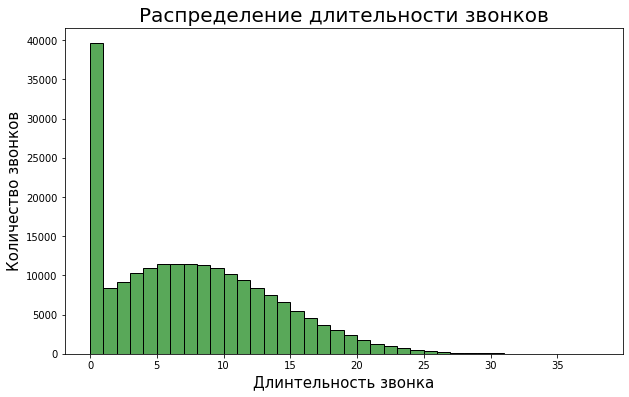

In [69]:
plt.figure(figsize=(10, 6))
plt.title('Распределение длительности звонков', fontsize=20)
plt.xlabel('Длинтельность звонка', fontsize=15)
plt.ylabel('Количество звонков', fontsize=15)
sns.histplot(data=data_calls.duration, binwidth=1, color='forestgreen')
plt.show()

На графике видно ~40 тысяч звонков длительностью 0 мин. Это пропущенные вызовы. Поэтому не будем их считать за аномалии.

### Проверка data_internet

In [44]:
data_internet.head()

,id,mb_used,session_date,user_id,session_month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [45]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             149396 non-null  object        
 1   mb_used        149396 non-null  float64       
 2   session_date   149396 non-null  datetime64[ns]
 3   user_id        149396 non-null  int64         
 4   session_month  149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 6.8+ MB


In [46]:
# проверка на дубликаты
print(f'Найдено дубликатов: {data_internet.duplicated().sum()}')

Найдено дубликатов: 0


In [76]:
# приведение типов данных
# data_internet to datetime
data_internet.session_date = pd.to_datetime(data_internet.session_date, format=DATA)
data_internet['session_month'] = pd.DatetimeIndex(data_internet['session_date']).month

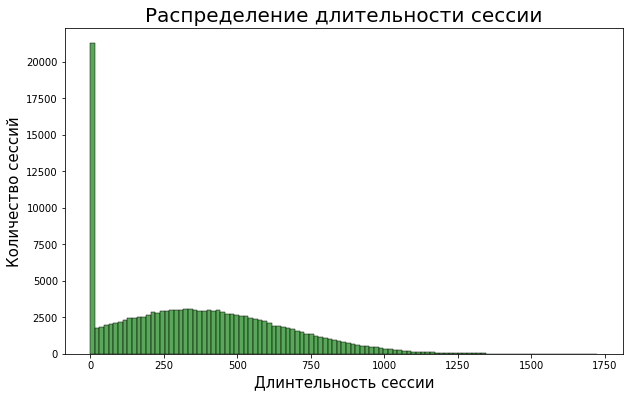

In [52]:
# Проверка на аномалии
plt.figure(figsize=(10, 6))
plt.title('Распределение длительности сессии', fontsize=20)
plt.xlabel('Длинтельность сессии', fontsize=15)
plt.ylabel('Количество сессий', fontsize=15)
sns.histplot(data=data_internet.mb_used, color='forestgreen')
plt.show()

### Проверка data_message

In [56]:
data_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [57]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [58]:
# проверка на дубликаты
print(f'Найдено дубликатов: {data_messages.duplicated().sum()}')

Найдено дубликатов: 0


In [59]:
# приведение типов данных
# data_internet to datetime
data_messages.message_date = pd.to_datetime(data_messages.message_date, format=DATA)
data_messages['message_month'] = pd.DatetimeIndex(data_messages['message_date']).month

### Проверка data_tariffs

In [60]:
data_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Проверка data_users

In [61]:
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [62]:
# Проверяем, переходил ли абонент на другой тариф
print(f'Количество пользователей, сменивших тариф: {data_users.user_id.duplicated().sum()}')

Количество пользователей, сменивших тариф: 0


In [63]:
print(f'Найдено дубликатов: {data_users.duplicated().sum()}')

Найдено дубликатов: 0


In [64]:
# data_internet to datetime
data_users.reg_date = pd.to_datetime(data_users.reg_date, format=DATA)
data_users['reg_month'] = pd.DatetimeIndex(data_users['reg_date']).month

### Посчитаем для каждого пользователя:
#### Колиство сделанных звонков и израсходованных минут разговора по месяцам

In [93]:
data_calls_pivot = data_calls.pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc=['count', 'sum'])
data_calls_pivot.columns = ['duration_count', 'duration_sum']
data_calls_pivot.head()

duration_count  duration_sum
user_id call_month                              
1000    5                       22           159
        6                       43           172
        7                       47           340
        8                       52           408
        9                       58           466

#### Количество отправленных сообщений по месяцам

In [91]:
data_messages_pivot = data_messages.pivot_table(index=['user_id', 'message_month'], values='id', aggfunc='count')
data_messages_pivot.columns = ['message_count']
data_messages_pivot.head()

message_count
user_id message_month               
1000    5                         22
        6                         60
        7                         75
        8                         81
        9                         57

#### Объем израсходованного интернет-трафика по месяцам

In [92]:
data_internet_pivot = data_internet.pivot_table(index=['user_id', 'session_month'], values='mb_used', aggfunc='sum')
data_internet_pivot.mb_used = np.ceil(data_internet_pivot.mb_used/1024).astype('int64')
data_internet_pivot.columns = ['Gb_used']
data_internet_pivot.head()

Gb_used
user_id session_month         
1000    5                    3
        6                   23
        7                   14
        8                   14
        9                   15

#### Помесячная выручка с каждого пользователя

Сделаем общую таблицу. Объеддиним data_calls_pivot, data_internet_pivot, data_messages_pivot

In [95]:
data = data_calls_pivot.join([data_internet_pivot, data_messages_pivot], how='outer').reset_index()
data = data.rename(columns={'level_1': 'month'})

In [96]:
# Переименуем столбец tariff_name в таблице с тарифами, чтобы слить с data
data_tariffs = data_tariffs.rename(columns={'tariff_name': 'tariff'})
data = data.merge(data_users, on='user_id', how='outer')
data = data.merge(data_tariffs, on='tariff')
data.head()

,user_id,month,duration_count,duration_sum,Gb_used,message_count,age,churn_date,city,first_name,...,reg_date,tariff,reg_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,22.0,159.0,3.0,22.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1
1,1000,6.0,43.0,172.0,23.0,60.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1
2,1000,7.0,47.0,340.0,14.0,75.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1
3,1000,8.0,52.0,408.0,14.0,81.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1
4,1000,9.0,58.0,466.0,15.0,57.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1


В результате мы получили одну таблицу - "помесячная статистика клиента". В ней можно найти всю информацию:
- месяц пользования
- суммарная длинтельность звонков
- количество звонков за месяц
- количество израссходованного трафика и др

#### Найдем суммарные выручки каждого тарифа и их разность

In [97]:
def get_profit(row):
    profit_message = 0
    profit_duration = 0
    profit_traffic = 0
    if row['messages_included'] < row['message_count']:
        profit_message = (row['message_count'] - row['messages_included']) * row['rub_per_message']
    if row['minutes_included'] < row['duration_sum']:
        profit_duration = (row['duration_sum'] - row['minutes_included']) * row['rub_per_minute']
    if row['mb_per_month_included'] < row['Gb_used']*1024:
        profit_traffic = (row['Gb_used']*1024 - row['mb_per_month_included'])/1024 * row['rub_per_gb']
    return profit_duration + profit_message + profit_traffic + row['rub_monthly_fee']

In [98]:
data['profit'] = data.apply(get_profit, axis=1)

In [101]:
smart_profit = data.query('tariff == "smart"')['profit'].sum()
ultra_profit = data.query('tariff == "ultra"')['profit'].sum()
print(f'Выручка от тарифа Smart: {smart_profit}')
print(f'Выручка от тарифа Ultra: {ultra_profit}')
print()
if smart_profit > ultra_profit:
    print(f'Выручка тарифа smart больше на {smart_profit-ultra_profit}')
else:
    print(f'Выручка тарифа ultra больше на {ultra_profit-smart_profit}')    

Выручка от тарифа Smart: 2875901.0
Выручка от тарифа Ultra: 2041050.0

Выручка тарифа smart больше на 834851.0


### Анализ данных
#### Расчет среднего, дисперсии, стандартного отклонения для минут разгоровора, сообщений, трафика для каждого тарифа. Графики.

In [102]:
data_monthly = data.pivot_table(index=['tariff'],
                              values=['duration_sum', 'Gb_used', 'message_count'],
                              aggfunc=['mean', 'std', 'var'])

In [103]:
data_monthly.columns = ['mean_gb_used', 'mean_duration_sum', 'mean_message_count',
                      'std_gb_used', 'std_duration_sum', 'std_message_count',
                      'var_gb_used', 'var_duration_sum', 'var_message_count']

In [104]:
# Расчет среднего, дисперсии, стандартного отклонения
data_monthly = data_monthly.reset_index()

In [105]:
data_monthly

,tariff,mean_gb_used,mean_duration_sum,mean_message_count,std_gb_used,std_duration_sum,std_message_count,var_gb_used,var_duration_sum,var_message_count
0,smart,16.336176,419.062978,38.716441,5.737923,189.325618,26.787949,32.923756,35844.189551,717.594201
1,ultra,19.694359,545.451104,61.161006,9.702924,306.925754,45.931026,94.146734,94203.418396,2109.659183


#### Построим диаграммы размаха

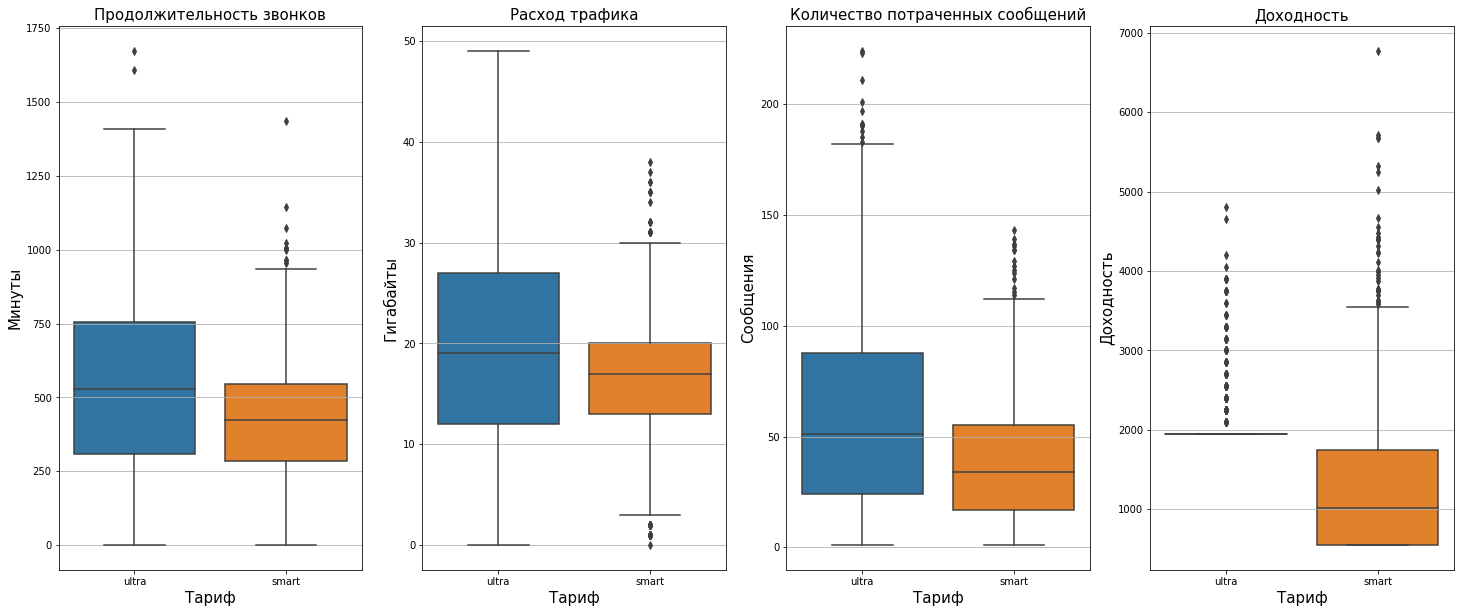

In [109]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 10))
sns.boxplot(data=data, x='tariff', y='duration_sum', ax=ax1)
ax1.set_title('Продолжительность звонков', fontsize=15)
ax1.grid(axis='y')
ax1.set_xlabel('Тариф', fontsize=15)
ax1.set_ylabel('Минуты', fontsize=15)
sns.boxplot(data=data, x='tariff', y='Gb_used', ax=ax2)
ax2.set_title('Расход трафика', fontsize=15)
ax2.grid(axis='y')
ax2.set_xlabel('Тариф', fontsize=15)
ax2.set_ylabel('Гигабайты', fontsize=15)
sns.boxplot(data=data, x='tariff', y='message_count', ax=ax3)
ax3.set_title('Количество потраченных сообщений', fontsize=15)
ax3.grid(axis='y')
ax3.set_xlabel('Тариф', fontsize=15)
ax3.set_ylabel('Сообщения', fontsize=15)
sns.boxplot(data=data, x='tariff', y='profit', ax=ax4)
ax4.set_title('Доходность', fontsize=15)
ax4.grid(axis='y')
ax4.set_xlabel('Тариф', fontsize=15)
ax4.set_ylabel('Доходность', fontsize=15)
plt.show()

Из графиков видно, что пользователи тарифа smart очень в среднем разговаривают несильно меньше пользователей тарифа ultra, поэтому пользователи smart часто переплачивают за дополнительные минуты разговора.То же самое касается и расхода трафика, и расхода sms сообщений. Кроме того, на последнем графике видно, что единичные пользователи тарифа ultra выходят за пределы абонентской платы. А вот пользователи тарифа smart наоборот - делают это очень часто. В среднем каждый пользователь тратит по 1000 руб. в месяц, что почти в 2 раза больше месчного платежа.

### Проверка гипотез

#### Выручка по тарифам

1. Нулевая гипотеза: средняя выручка пользователей тарифов не отличается.
2. Альтернативная гипотеза: средняя выручка пользователей тарифов отличается

In [115]:
# Пороговое значение
alpha = .05
profit_smart = data.query('tariff == "smart"')['profit']
profit_ultra = data.query('tariff == "ultra"')['profit']
# проверка гипотезы о равенстве средних
results = st.ttest_ind(profit_smart, profit_ultra, equal_var = False)
print(f'pvalue = {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не отвергаем гипотезу')

pvalue = 1.927011394420941e-250
Отвергаем гипотезу


#### Выручка по Москве и другим городам

1. Нулевая гипотеза: средние выручки пользователей из Москвы и других городов не отличаются.
2. Альтернативная гипотеза: средние выручки пользователей из Москвы и других городов отличаются.

In [116]:
profit_moscow = data.query('city == "Москва"')['profit']
profit_other = data.query('city != "Москва"')['profit']
# проверка гипотезы
results = st.ttest_ind(profit_moscow, profit_other, equal_var = False)
print(f'pvalue = {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не отвергаем гипотезу')

pvalue = 0.5216952110000278
Не отвергаем гипотезу


### Вывод.
Исследовав предоставленные данные можно сказать, что:
1. Примерно 25% пользователей тарифа smart выходят за лимиты предоставленных 550 минут. В то время, как клиенты тарифа ultra вообще не пересекают предел.
2. Примерно 75% пользователей тарифа smart выходят за лимит предоставленного трафика в 15Гб. В среднем в месяц расходуется 17-18Гб. Основная же масса клиентов тарифа ultra не выходят за предоставленный предел в 30Гб. В среднем в месяц расходуется 18-19Гб.
3. Чуть более 25% пользователей тарифа smart выходят за лимит предоставленных sms сообщений. В среднем в месяц расзодуют 30-35. В то время как пользователи тарифа ultra не превышают лимита. Для тарифа ultra среднее значение израсходованных сообщений - 50.
4. Пользователи тарифа ultra в основном не тратят больше абонентской платы. А вот средний месячных платеж пользователя тарифа smart - 1000руб, что почти в 2 раза превосходит абонентскую плату. А за счет большого количества пользователей тарифа smart, доходность одноименного тарифа выше.
5. Пользователи Москвы приносят примерно столько же дохода сколько и пользователи остальных регионов вместе взятых.